In [1]:
import numpy as np
from scipy.optimize import minimize
from scipy.optimize import fsolve
from matplotlib import pyplot as plt
import pandas as pd

In [6]:
def calc_price(theta1, theta2, mu1, mu2, cost):
    """compute each insurer's price (assumes interior solution)"""
    p1 = (2.*theta1*mu1+theta2*mu2)/3. + cost
    p2 = (2.*theta2*mu2+theta1*mu1)/3. + cost
    return np.maximum(p1,0), np.maximum(p2,0)
  
    
def calc_t(theta1, theta2, mu1, mu2, cost):
    """compute the proportion of people choosing each insurer"""
    p1, p2 = calc_price(theta1, theta2, mu1, mu2, cost)
    t_hat = .5 + (p2 - p1)/(2.*cost)
    return np.clip(t_hat,0,1)


def calc_profits(theta1, theta2, mu1, mu2, cost):
    """compute profits for each firm"""
    p1, p2 = calc_price(theta1, theta2, mu1, mu2, cost)
    t1 = calc_t(theta1, theta2, mu1, mu2, cost)
    return t1*np.maximum(p1-theta1*mu1,0)


def hosp_profits(theta1,theta2,mu1,mu2,cost):
    t1 = calc_t(theta1, theta2, mu1, mu2, cost)
    return t1*theta1*mu1 +  (1-t1)*theta2*mu2 


def outside_seq(theta1,mu1):
    """assume interior solution"""
    return mu1*theta1

    
def outside_simlt(mu1,cost,listprice):
    """outside option in simult case"""
    return (listprice - cost)/2

    
#arbitrary outside option...
def nash_in_nash(theta1, theta2, mu1, mu2, cost, outside):
    term1 = calc_profits(theta1, theta2, mu1, mu2, cost)
    term2 = max(hosp_profits(theta1,theta2,mu1,mu2,cost)-outside,0)
    obj = -1*(term1*term2)**.5
    return obj

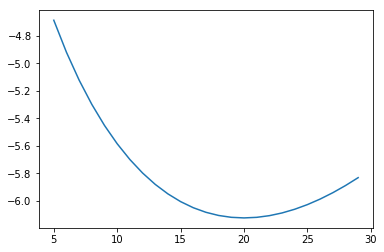

In [7]:
plt.plot([i for i in range(5,30)],  [nash_in_nash(i, 20, .5, .5, 10, 2.5) for i in range(5,30)])

In [8]:
def bargain_helper(theta1, theta2, mu1, mu2, cost, listprice):
    """solve each firm 1s optimization holding theta 2 fixed"""
    outside = outside_simlt(mu2,cost,listprice)
    result = minimize(nash_in_nash, theta1, args=(theta2, mu1, mu2, cost, outside),
                      method='Nelder-Mead', options={'disp': False})
    return result.x


print(bargain_helper(20, 20, .5, .5, 10, 15))

[20.]


In [9]:
def simult_bargain(theta1, theta2, mu1, mu2, cost, listprice):
    """solve the bargaining problems seperately and iterate for a solution"""       
    
    #loop variables
    diff =  theta1

    maxiter = 10
    while maxiter >=0 and diff > 10e-7:
        #seems as though there is a contraction mapping here, need to think more about why
        theta1 = bargain_helper(theta1, theta2, mu1, mu2, cost, listprice)
        theta2 = bargain_helper(theta2, theta1, mu2, mu1, cost,  listprice)
        
        #update loop variables
        diff = np.abs(np.max(theta1 - theta2))
        maxiter = maxiter-1
        
    return theta1, theta2


print(simult_bargain(15,15,.5,.5,10,15))

(array([19.99999263]), array([20.00002031]))


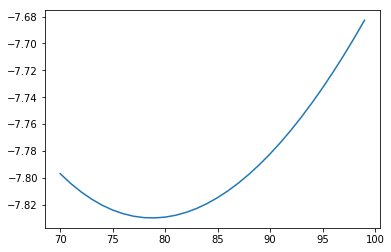

In [14]:
def seq_obj(theta1, mu1, mu2, cost, listprice):
    """ theta1 is a guess for the first stage """
    outside2  = outside_seq(theta1,mu1) #outside option for second stage
    outside1 = outside_simlt(mu2,cost,listprice) #outside option for first stage
    
    #compute the first stage
    #this is not right... need to ensure that you can't amp up theta1 too high
    #market shares are not right, no one is buying...
    theta2 = bargain_helper(theta1, theta1, mu2, mu1, cost, outside2)
    return nash_in_nash(theta1, theta2, mu1, mu2, cost, outside1)

plt.plot([i for i in range(70,100)],  [seq_obj(i, .5, .5, 10, 15) for i in range(70,100)])

In [17]:
def seq_bargain(theta1, mu1, mu2, cost, listprice):
    """solve the bargaining problems seperately,
    then solve for the solution"""   
    #only compute no deal 1x for initial
    result = minimize(seq_obj, theta1, args=(mu1, mu2, cost, listprice),
                      method='Nelder-Mead', options={'disp': False})
    theta1 = result.x
    theta2 = bargain_helper(theta1, theta1, mu2, mu1, cost, listprice)
    return theta1, theta2


print(seq_bargain(18,.5,.5,10,15))

(array([78.7835083]), array([46.04632551]))


In [16]:
def make_table(arg, steps, params):
    min_arg, max_arg, no_step = steps
    
    cols = ['eq_type','distance_cost','mc1','mc2','profit1','profit2','hosp_profit','share1','share2']
    
    indep_var = np.linspace(min_arg, max_arg, no_step)
    results = []
    
    for var in indep_var:
        param_copy = list(params)
        param_copy[arg] = var
        mu1,mu2,cost,outside = param_copy
        for eq_type in ['Simultaneous', 'Sequential']:
            
            mc1,mc2 = 10, 10
            
            if eq_type == 'Simultaneous':
                mc1,mc2 = simult_bargain(mc1,mc2, mu1, mu2, cost, outside)
            else:
                mc1,mc2 = seq_bargain(mc1, mu1, mu2, cost, outside)
            mc1, mc2 = mc1[0],mc2[0]
            profit1 = calc_profits(mc1, mc2, mu1, mu2, cost)
            profit2 = calc_profits(mc2, mc1, mu2, mu1, cost)
            hosp_prof = hosp_profits(mc1, mc2, mu1, mu2, cost)
            share1 = calc_t(mc1, mc2, mu1, mu2, cost)
            share2 = 1-share1
            results.append([eq_type,cost,mc1,mc2,profit1,profit2,hosp_prof, share1,share2])
            
        
    return pd.DataFrame(data=results, columns=cols)
    

make_table(2,(10,20,2), (.5,.5,30,0))

,eq_type,distance_cost,mc1,mc2,profit1,profit2,hosp_profit,share1,share2
0,Simultaneous,10.0,5.000006,4.999988,4.999997,5.000003,2.499999,0.500000,0.500000
1,Sequential,10.0,62.002441,30.030162,1.091046,11.748472,18.748873,0.233564,0.766436
2,Simultaneous,20.0,10.000000,10.000000,10.000000,10.000000,5.000000,0.500000,0.500000
3,Sequential,20.0,124.252441,60.201081,2.173785,23.524238,37.566346,0.233119,0.766881
